In [1]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import pymongo
%matplotlib inline

In [2]:
client = pymongo.MongoClient()
repo = client.repo
repo.authenticate('balawson', 'balawson')

True

In [3]:
startTime = datetime.datetime.now()
tweets     = pd.read_csv('../../twitter/2016-02-25.csv', index_col=0)
tweets.columns = ['lat', 'locations', 'lng', 'source', 'time', '_id', 'user']
gowalla    = pd.DataFrame(list(repo.balawson.gowalla.find()))
brightkite = pd.DataFrame(list(repo.balawson.brightkite.find()))

In [4]:
tweets    ['time'] = pd.to_datetime(tweets.time,unit='ms')
brightkite['time'] = pd.to_datetime(brightkite.time)
gowalla   ['time'] = pd.to_datetime(gowalla.time)
for dataframe in [tweets, brightkite, gowalla]:
    dataframe['date']=dataframe.apply(lambda d:getattr(d.time, 'date')(), axis=1)


In [5]:
tweets.head()

,lat,locations,lng,source,time,_id,user,date
0,42.350887,"BOSTON, MASS/ CHICAGO,IL",-71.064857,twitter,2015-05-11 15:07:43.868,597780130006757376,30773472,2015-05-11
1,42.351974,"Boston, MA",-71.124535,twitter,2015-05-18 15:23:18.132,600320763653132288,54988729,2015-05-18
2,42.266403,"boston, ma",-71.112167,twitter,2015-05-18 15:25:03.942,600321207452508161,97579042,2015-05-18
3,42.368088,Boston,-71.057663,twitter,2015-05-18 15:26:22.351,600321536323629056,22079002,2015-05-18
4,42.350098,Rhode Island,-71.156441,twitter,2015-05-18 15:27:09.142,600321732579237888,379141823,2015-05-18


In [88]:
gowalla.head()

,_id,lat,lng,location,time,user
0,56d2278dcf38dc28e955d0ff,42.352905,-71.132607,142466,2010-02-02 00:45:12,121109
1,56d2278dcf38dc28e955d100,42.346096,-71.137183,1400325,2010-07-17 04:22:23,86307
2,56d2278dcf38dc28e955d101,42.346223,-71.097776,17045,2010-08-18 22:49:28,2586
3,56d2278dcf38dc28e955d102,42.368052,-71.072061,963611,2010-04-20 19:32:59,786
4,56d2278dcf38dc28e955d103,42.373342,-71.119702,1536840,2010-08-19 17:29:58,3252


In [7]:
def print_description(dataframe):
    print('start date:', min(dataframe.date))
    print('end date:', max(dataframe.date))
    print('duration:', max(dataframe.date) - min(dataframe.date))
    
    print('number of users:', len(set(dataframe.user)))
    print('number of posts:', dataframe._id.count())
    print('average number of posts per user', dataframe._id.count()/float(len(set(dataframe.user))))

In [8]:
print_description(brightkite)

start date: 2008-04-14
end date: 2010-10-18
duration: 917 days, 0:00:00
number of users: 1383
number of posts: 31928
average number of posts per user 23.0860448301


In [9]:
print_description(gowalla)

start date: 2009-04-23
end date: 2010-10-22
duration: 547 days, 0:00:00
number of users: 2395
number of posts: 39398
average number of posts per user 16.4501043841


In [10]:
print_description(tweets)

start date: 2015-05-11
end date: 2016-02-26
duration: 291 days, 0:00:00
number of users: 39540
number of posts: 632990
average number of posts per user 16.0088517956


In [12]:
def plot_groups(dataframe, column, title=None, avg= False, special_kind='bar'):
    groups = {}
    dataframe[column]=dataframe.apply(lambda d:getattr(d, column), axis=1)
    for group, group_data in dataframe.groupby(column):
        if group_data[column].count():
            if avg:
                groups[group] = group_data[column].count() / float(len(dataframe))
            else:
                groups[group] = group_data[column].count()

    temp_df = pd.Series(list(groups.itervalues()),index= list(groups.iterkeys()))
    if special_kind: temp_df.plot(kind=special_kind, figsize=(20,8), title=title)
    if not(special_kind): temp_df.plot( figsize=(20,8), title=title)

In [30]:
def plot_timegroups(dataframe, column, title=None, avg = False):
    groups = {}
    for group, group_data in dataframe.groupby(column):
        if group_data[column].count():
            if avg:
                groups[group] = group_data[column].count() / float(len(dataframe))
            else:
                groups[group] = group_data[column].count()
                
    start = min(dataframe.time).date() - pd.Timedelta('5 days')
    end   = max(dataframe.time).date() + pd.Timedelta('5 days')
    i = pd.date_range(start, end, freq='D')

    temp_df = pd.Series(list(iter(groups.values())),index= list(iter(groups.keys())))
    #if dateFlag: temp_df = pd.Series(temp_df, index=i)
    temp_df.plot(figsize=(20,8), title=title, legend=True)

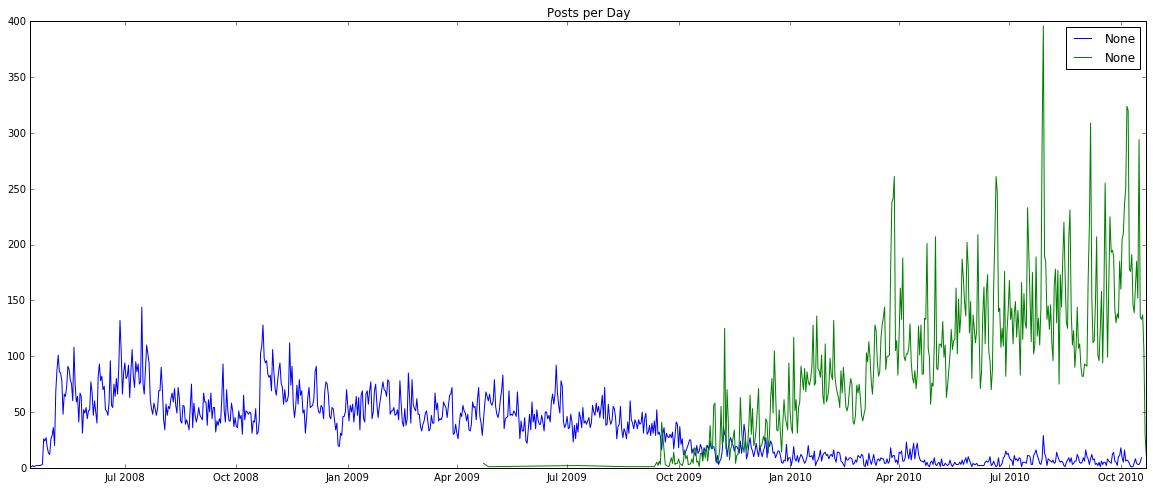

In [33]:
plot_timegroups(brightkite, 'date', 'Posts per Day')
plot_timegroups(gowalla, 'date', 'Posts per Day')
plot_timegroups(tweets, 'date', 'Posts per Day')

In [20]:
pd.DataFrame.plot?

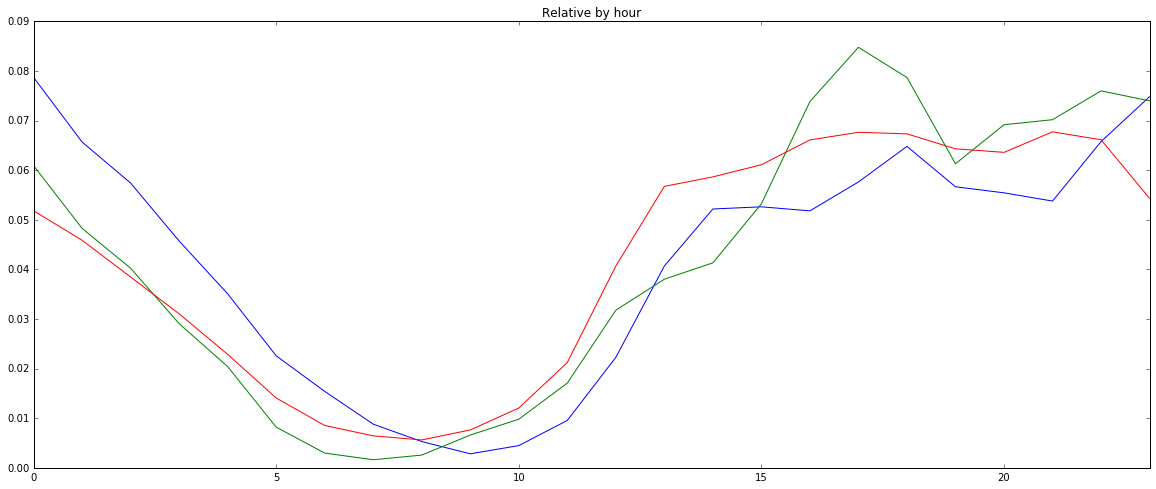

In [15]:
plot_timegroups(brightkite, 'hour', 'Relative Posts by hour', avg= True)
plot_timegroups(gowalla, 'hour', 'Relative by hour', avg=True)
plot_timegroups(tweets, 'hour', 'Relative by hour', avg= True)

In [40]:
#http://nbviewer.jupyter.org/gist/bburky/7763555/folium-ipython.ipynb
from IPython.display import HTML
def inline_map(map):
    """
    Embeds the HTML source of the map directly into the IPython notebook.
    
    This method will not work if the map depends on any files (json data). Also this uses
    the HTML5 srcdoc attribute, which may not be supported in all browsers.
    """
    map._build_map()
    return HTML('<iframe srcdoc="{srcdoc}" style="width: 100%; height: 510px; border: none"></iframe>'.format(srcdoc=map.HTML.replace('"', '&quot;')))

def embed_map(map, path="map.html", html=True):
    """
    Embeds a linked iframe to the map into the IPython notebook.
    
    Note: this method will not capture the source of the map into the notebook.
    This method should work for all maps (as long as they use relative urls).
    """
    map.create_map(path=path)
    if html: return HTML('<iframe src="files/{path}" style="width: 100%; height: 510px; border: none"></iframe>'.format(path=path))
    return '<iframe src="{path}" style="width: 100%; height: 510px; border: none"></iframe>'.format(path=path)

In [41]:
def plot_timegroups(dataframe, column, title=None,avg = False):
    groups = {}
    try: #date is a function, so if that is passed in we need to call it
         dataframe[column]=dataframe.apply(lambda d:getattr(d.time, column)(), axis=1)
         dateFlag = True
    except TypeError: #if it a month/hour/day of week attribute
         dataframe[column]=dataframe.apply(lambda d:getattr(d.time, column), axis=1)
         dateFlag = False
    for group, group_data in dataframe.groupby(column):
        if group_data[column].count():
            if avg:
                groups[group] = group_data[column].count() / float(len(dataframe))
            else:
                groups[group] = group_data[column].count()
    start = min(dataframe.time).date() - pd.Timedelta('5 days')
    end   = max(dataframe.time).date() + pd.Timedelta('5 days')
    i = pd.date_range(start, end, freq='D')

    temp_df = pd.Series(list(iter(groups.values())),index= list(iter(groups.keys())))
    if dateFlag: temp_df = pd.Series(temp_df, index=i)
    temp_df.plot(figsize=(20,8), title=title)

In [42]:
#http://www.jackboot7.com/visualizing-tweets.html
#Thank you Luis Alberto Santana
import folium
from folium import plugins

# Create a heatmap with the data.
heatmap_map = folium.Map(location=[42.359716, -71.065917], zoom_start=12)
heatmap_map.add_children(plugins.HeatMap([(row.lat, row.lng) for idx, row in gowalla.iterrows()], radius = 10))
embed_map(heatmap_map)

/home/jedidiah/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: FutureWarning: Map.create_map is deprecated. Use Map.save instead


In [56]:
import os, time
from selenium import webdriver
from pyvirtualdisplay import Display


def make_heatmap(df, count):
    heatmap_map = folium.Map(location=[42.359716, -71.065917], zoom_start=12)
    heatmap_map.add_children(plugins.HeatMap([(row.lat, row.lng) for idx, row in df.iterrows()], radius = 10))
    take_png('test{0}.html'.format(count), heatmap_map, count)


def take_png(filename, mapobject, count):
    delay = 3
    tmpurl='file://{path}/{mapfile}'.format(path=os.getcwd(),mapfile=filename)
    mapobject.save(filename)
    '''
    html = '<h1>from {}00 to {}00</h1>'.format(str(count),int(count)+1)
    html += embed_map(mapobject, html=False)
    
    
    with open('map.html', 'a+') as file:
        file.writelines(html)
    '''   
    display = Display(visible=0, size=(800, 600))
    display.start()
    
    browser = webdriver.Firefox()
    browser.get(tmpurl)
    time.sleep(delay)
    browser.save_screenshot('{0}.png'.format(filename))
    browser.quit()
    display.stop()

In [64]:
def plot_heatgroups(dataframe, column, name='gowalla'):
    groups = {}
    try: #date is a function, so if that is passed in we need to call it
         dataframe[column]=dataframe.apply(lambda d:getattr(d.time, column)(), axis=1)
         dateFlag = True
    except TypeError: #if it a month/hour/day of week attribute
         dataframe[column]=dataframe.apply(lambda d:getattr(d.time, column), axis=1)
         dateFlag = False
    for group, group_data in dataframe.groupby(column):
        if group_data[column].count():
            make_heatmap(group_data, str(group))
    
    #need imagemagick
    os.popen('convert -delay 20 -loop 1 *png {0}.gif'.format(name))
    time.sleep(30) #make sure the convert process finishes before all the pngs are deleted
    os.popen('rm *.png')

In [ ]:
plot_heatgroups(brightkite, 'hour', 'brightkite')

In [65]:
plot_heatgroups(gowalla, 'hour', 'gowalla')

In [67]:
plot_heatgroups(tweets, 'hour', 'twitter')

In [ ]:
endTime = datetime.datetime.now()

import prov
# Create the provenance document describing everything happening
# in this script. Each run of the script will generate a new
# document describing that invocation event. This information
# can then be used on subsequent runs to determine dependencies
# and "replay" everything. The old documents will also act as a
# log.


doc = prov.model.ProvDocument()
doc.add_namespace('alg', 'http://datamechanics.io/algorithm/balawson/') # The scripts in <folder>/<filename> format.
doc.add_namespace('dat', 'http://datamechanics.io/data/balawson/') # The data sets in <user>/<collection> format.
doc.add_namespace('ont', 'http://datamechanics.io/ontology#') # 'Extension', 'DataResource', 'DataSet', 'Retrieval', 'Query', or 'Computation'.
doc.add_namespace('log', 'http://datamechanics.io/log#') # The event log.
doc.add_namespace('snap', 'https://snap.stanford.edu/data/')
doc.add_namespace('bal', 'http://people.bu.edu/balawson/')

this_script = doc.agent('alg:data-viz', {prov.model.PROV_TYPE:prov.model.PROV['SoftwareAgent'], 'ont:Extension':'py'})
brightkite_resource = doc.entity('snap:brightkite', {'prov:label':'SNAP: Standford Network Analysis Project - Brightkite', prov.model.PROV_TYPE:'ont:DataResource', 'ont:Extension':'txtgz'})
gowalla_resource = doc.entity('snap:gowalla', {'prov:label':'SNAP: Standford Network Analysis Project - Gowalla', prov.model.PROV_TYPE:'ont:DataResource', 'ont:Extension':'txtgz'})
twitter_resource = doc.entity('bal:twitter', {'prov:label':'Sample of Curated Tweet', prov.model.PROV_TYPE:'ont:DataResource', 'ont:Extension':'csv'})

viz_brightkite = doc.activity('log:a'+str(uuid.uuid4()), startTime, endTime, {prov.model.PROV_TYPE:'ont:Computation'})
viz_gowalla = doc.activity('log:a'+str(uuid.uuid4()), startTime, endTime, {prov.model.PROV_TYPE:'ont:Computation'})
viz_gowalla = doc.activity('log:a'+str(uuid.uuid4()), startTime, endTime, {prov.model.PROV_TYPE:'ont:Computation'})

doc.wasAssociatedWith(viz_brightkite, this_script)
doc.wasAssociatedWith(viz_gowalla, this_script)
doc.wasAssociatedWith(viz_twitter, this_script)

doc.used(viz_brightkite, brightkite_resource, startTime)
doc.used(viz_gowalla, gowalla_resource, startTime)
doc.used(viz_twitter, twitter_resource, startTime)

brightkite_ent = doc.entity('dat:brightkite', {prov.model.PROV_LABEL:'Brightkite data', prov.model.PROV_TYPE:'ont:DataSet'})
doc.wasAttributedTo(brightkite_ent, this_script)
doc.wasGeneratedBy(brightkite_ent, get_brightkite, endTime)
doc.wasDerivedFrom(brightkite_ent, brightkite_resource, get_brightkite, get_brightkite, get_brightkite)

gowalla_ent = doc.entity('dat:gowalla', {prov.model.PROV_LABEL:'Gowalla dataset', prov.model.PROV_TYPE:'ont:DataSet'})
doc.wasAttributedTo(gowalla_ent, this_script)
doc.wasGeneratedBy(gowalla_ent, get_gowalla, endTime)
doc.wasDerivedFrom(gowalla_ent, gowalla_resource, get_gowalla, get_gowalla, get_gowalla)

twitter_ent = doc.entity('dat:twitter', {prov.model.PROV_LABEL:'Twitter dataset', prov.model.PROV_TYPE:'ont:DataSet'})
doc.wasAttributedTo(twitter_ent, this_script)
doc.wasGeneratedBy(twitter_ent, get_twitter, endTime)
doc.wasDerivedFrom(twitter_ent, twitter_resource, get_twitter, get_twitter, get_twitter)

repo.record(doc.serialize()) # Record the provenance document.
#print(json.dumps(json.loads(doc.serialize()), indent=4))
open('plan.json','w').write(json.dumps(json.loads(doc.serialize()), indent=4))
print(doc.get_provn())
repo.logout()

